In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import itertools
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [11]:
HomeB_MeterData = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/HomeB-2014/HomeB-meter1_2014.csv')
HomeC_MeterData = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/HomeC-2015/HomeC-meter1_2015.csv')
HomeF_MeterData = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/HomeF-2016/HomeF-meter3_2016.csv')


HomeB_MeterData.index = pd.to_datetime(HomeB_MeterData['Date & Time'])
HomeC_MeterData.index = pd.to_datetime(HomeC_MeterData['Date & Time'])
HomeF_MeterData.index = pd.to_datetime(HomeF_MeterData['Date & Time'])


HomeB_MeterData = HomeB_MeterData.resample("30T").sum()
HomeC_MeterData = HomeC_MeterData.resample("30T").sum()
HomeF_MeterData = HomeF_MeterData.resample("30T").sum()

HomeB_MeterData = HomeB_MeterData.reset_index()
HomeC_MeterData = HomeC_MeterData.reset_index()
HomeF_MeterData = HomeF_MeterData.reset_index()

In [12]:
HomeB_MeterData_Nov = HomeB_MeterData[pd.to_datetime(HomeB_MeterData['Date & Time']).dt.month==11]
HomeB_MeterData_Nov_Two_weeks =  HomeB_MeterData_Nov[:672]
HomeB_MeterData_Nov_Two_weeks = HomeB_MeterData_Nov_Two_weeks.reset_index(drop=True)


HomeC_MeterData_Nov = HomeC_MeterData[pd.to_datetime(HomeC_MeterData['Date & Time']).dt.month==11]
HomeC_MeterData_Nov_Two_weeks =  HomeC_MeterData_Nov[:672]
HomeC_MeterData_Nov_Two_weeks = HomeC_MeterData_Nov_Two_weeks.reset_index(drop=True)


HomeF_MeterData_Nov = HomeF_MeterData[pd.to_datetime(HomeF_MeterData['Date & Time']).dt.month==11]
HomeF_MeterData_Nov_Two_weeks =  HomeF_MeterData_Nov[:672]
HomeF_MeterData_Nov_Two_weeks = HomeF_MeterData_Nov_Two_weeks.reset_index(drop=True)

# The offline optimization problem using CVX in Python. 

**Below is the code for the Static offline optimization.**



**HOUSE B**

In [14]:
import cvxpy as cp
import numpy as np
from cvxpy.atoms.elementwise.maximum import maximum as cpMax
p = 0.2
a = 2
y = np.array(HomeB_MeterData_Nov_Two_weeks['use [kW]']) 
x = cp.Variable()
obj = 0
for i in range(len(y)):
  obj = obj + (p*x + a*cpMax(0, y[i]-x))
objective = cp.Minimize(obj)
prob = cp.Problem(objective)
result = prob.solve()
print(x.value)

0.9092977780968707


In [15]:
result

193.02462686933774

The Value obtained for static optimization is **0.9075649999976861**

The Result for Power in KWh is **193.02462686933774**


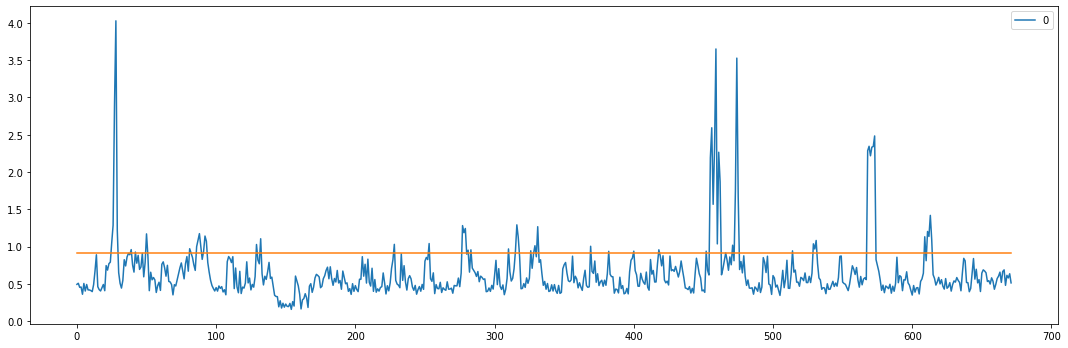

In [16]:
static_optimized_df = pd.DataFrame({"static_data": [x.value]*len(y)})
static_optimized_df.static_data = static_optimized_df.static_data.astype(float)
actual_value_y_df =  pd.DataFrame(y)

fig, axes = plt.subplots(figsize=(15,5))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

actual_value_y_df.plot.line(ax=axes)
static_optimized_df["static_data"].plot.line(ax=axes)

**House C**

1.3256866737166901


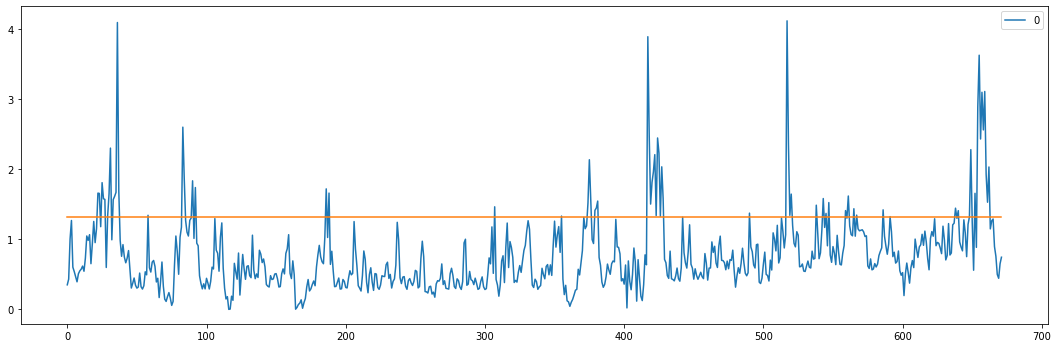

In [17]:
import cvxpy as cp
import numpy as np
from cvxpy.atoms.elementwise.maximum import maximum as cpMax
p = 0.2
a = 2
y = np.array(HomeC_MeterData_Nov_Two_weeks['use [kW]']) 
x = cp.Variable()
obj = 0
for i in range(len(y)):
  obj = obj + (p*x + a*cpMax(0, y[i]-x))
objective = cp.Minimize(obj)
prob = cp.Problem(objective)
result = prob.solve()
print(x.value)

static_optimized_df = pd.DataFrame({"static_data": [x.value]*len(y)})
static_optimized_df.static_data = static_optimized_df.static_data.astype(float)
actual_value_y_df =  pd.DataFrame(y)

fig, axes = plt.subplots(figsize=(15,5))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

actual_value_y_df.plot.line(ax=axes)
static_optimized_df["static_data"].plot.line(ax=axes)

In [18]:
result

257.28038579942967

The Value obtained for static optimization is **1.3256866733775459**

The Result for Power in KWh is **257.28038579942967**



**House F**

121.2783344056514


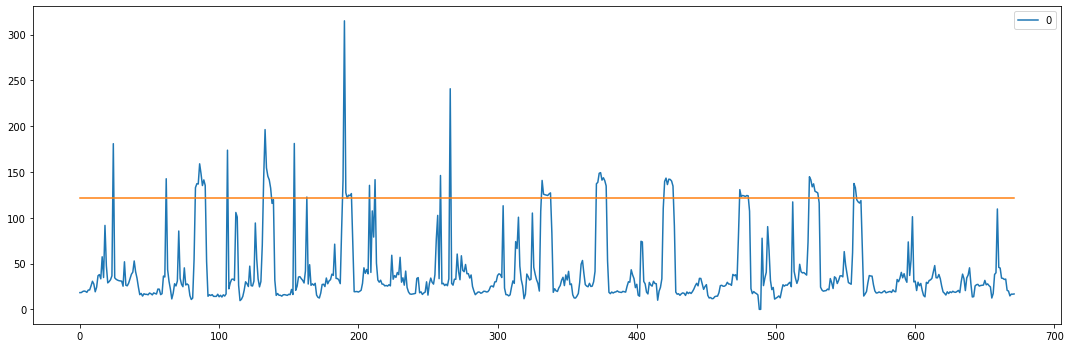

In [19]:
import cvxpy as cp
import numpy as np
from cvxpy.atoms.elementwise.maximum import maximum as cpMax
p = 0.2
a = 2
y = np.array(HomeF_MeterData_Nov_Two_weeks['Usage [kW]']) 
x = cp.Variable()
obj = 0
for i in range(len(y)):
  obj = obj + (p*x + a*cpMax(0, y[i]-x))
objective = cp.Minimize(obj)
prob = cp.Problem(objective)
result = prob.solve()
print(x.value)

static_optimized_df = pd.DataFrame({"static_data": [x.value]*len(y)})
static_optimized_df.static_data = static_optimized_df.static_data.astype(float)
actual_value_y_df =  pd.DataFrame(y)

fig, axes = plt.subplots(figsize=(15,5))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

actual_value_y_df.plot.line(ax=axes)
static_optimized_df["static_data"].plot.line(ax=axes)

In [20]:
result

19154.15893700204

The Value obtained for static optimization is **1.5280333340016716**

The Result for Power in KWh is **19154.15893700204**

**Below is the code for the Dynamic optimization.**

**House B**

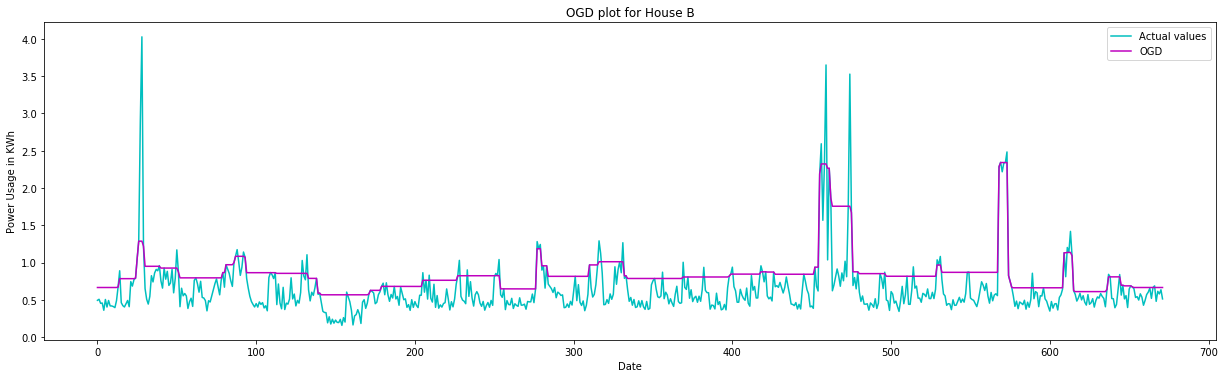

In [32]:
import cvxpy as cp
import numpy as np
from cvxpy.atoms.elementwise.maximum import maximum as cpMax
from cvxpy.atoms.elementwise.abs import abs as cpAbs
p = 0.2
a = 2
b= 2
y = np.array(HomeB_MeterData_Nov_Two_weeks['use [kW]'])
x = cp.Variable(len(y))
obj = 0
for i in range(len(y)):
  obj = obj + (p*x[i] + a*cpMax(0, y[i]-x[i]) + b*cpAbs(x[i]-x[i-1]))
objective = cp.Minimize(obj)
prob = cp.Problem(objective)
result = prob.solve()
# print("The Value obtained for dynamic optimization is ", x.value)

dynamic_optimized_df = pd.DataFrame(x.value) 
actual_value_y_df =  pd.DataFrame(y) 

fig, axes = plt.subplots(figsize=(17,5))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]

plt.plot(actual_value_y_df, 'c', label="Actual values")
plt.plot(dynamic_optimized_df,'m', label='OGD')
axes.set(title='OGD plot for House B', xlabel='Date', ylabel='Power Usage in KWh')
plt.legend(loc='upper right')
plt.show()


In [33]:
result

160.56728356495924

The Result for Power in KWh is **160.56728356495924**

**House C**

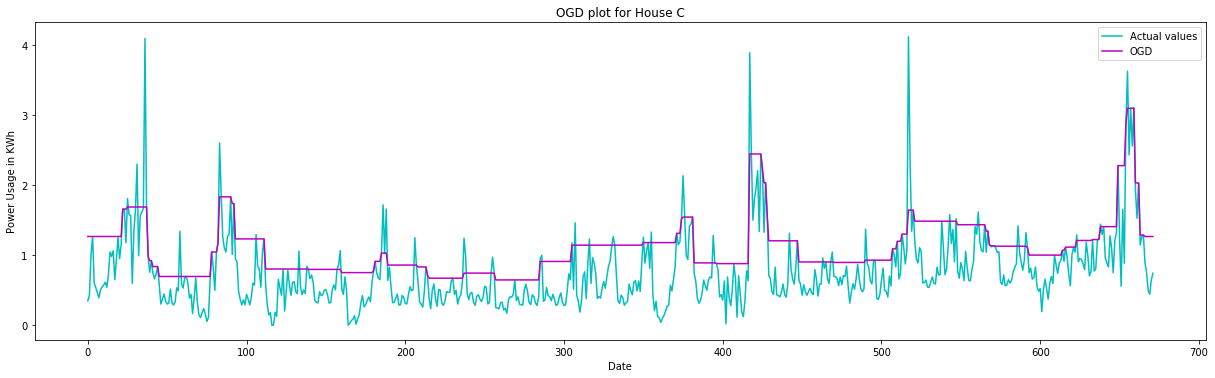

In [34]:
p = 0.2
a = 2
b= 2
y = np.array(HomeC_MeterData_Nov_Two_weeks['use [kW]'])
x = cp.Variable(len(y))
obj = 0
for i in range(len(y)):
  obj = obj + (p*x[i] + a*cpMax(0, y[i]-x[i]) + b*cpAbs(x[i]-x[i-1]))
objective = cp.Minimize(obj)
prob = cp.Problem(objective)
result = prob.solve()
# print("The Value obtained for dynamic optimization is ", x.value)

dynamic_optimized_df = pd.DataFrame(x.value) 
actual_value_y_df =  pd.DataFrame(y) 

fig, axes = plt.subplots(figsize=(17,5))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

date = [dt for dt in pd.date_range(HomeC_MeterData_Nov_Two_weeks['Date & Time'][0], HomeC_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]
plt.plot(actual_value_y_df, 'c', label="Actual values")
plt.plot(dynamic_optimized_df,'m', label='OGD')
axes.set(title='OGD plot for House C', xlabel='Date', ylabel='Power Usage in KWh')
plt.legend(loc='upper right')
plt.show()

In [35]:
result

209.9704980812344

The Result for Power in KWh is **209.9704980812344**

**House F**

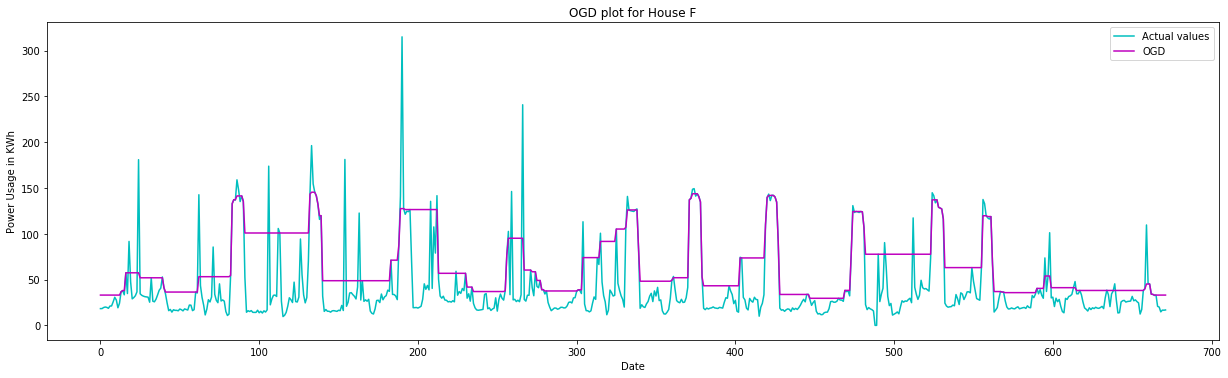

In [36]:
p = 0.2
a = 2
b= 2
y = np.array(HomeF_MeterData_Nov_Two_weeks['Usage [kW]'])
x = cp.Variable(len(y))
obj = 0
for i in range(len(y)):
  obj = obj + (p*x[i] + a*cpMax(0, y[i]-x[i]) + b*cpAbs(x[i]-x[i-1]))
objective = cp.Minimize(obj)
prob = cp.Problem(objective)
result = prob.solve()
# print("The Value obtained for dynamic optimization is ", x.value)

dynamic_optimized_df = pd.DataFrame(x.value) 
actual_value_y_df =  pd.DataFrame(y) 

fig, axes = plt.subplots(figsize=(17,5))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]
plt.plot(actual_value_y_df, 'c', label="Actual values")
plt.plot(dynamic_optimized_df,'m', label='OGD')
axes.set(title='OGD plot for House F', xlabel='Date', ylabel='Power Usage in KWh')
plt.legend(loc='upper right')
plt.show()

In [37]:
result

14746.35253125241

The Result for Power in KWh is **14746.35253125241**



# Online Gradient Descent

**House B**

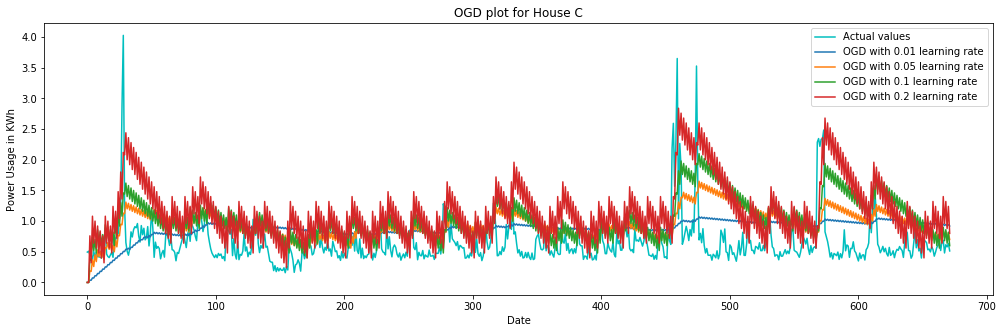

In [40]:
LR = [0.01, 0.05, 0.1, 0.2]
data = np.array(HomeB_MeterData_Nov_Two_weeks['use [kW]'])

p = 0.2
a = 2
b = 2

OGD_vals = []
output_vals = []

for rate in LR:
  x = np.zeros(672)
  s = 0
  for t in range(1, 671):
    if data[t] < x[t]:
      if x[t] > x[t-1]:
        cost = p+b
      else:
        cost = p-b
    else:
      if x[t] > x[t-1]:
        cost = p-a+b
      else:
        cost = p-a-b;

    x[t+1] = x[t] - rate * cost;

  for i in range(1, 671):
    s = s + p*x[i] + a*max(0,data[i] - x[i])+ b*abs(x[i] - x[i-1]);

  OGD_vals.append(x)
  output_vals.append(s)

ind = 0
date = [dt for dt in pd.date_range(HomeB_MeterData_Nov_Two_weeks['Date & Time'][0], HomeB_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]

fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='OGD plot for House C', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for rate in LR:
  plt.plot(OGD_vals[ind], label='OGD with '+ str(rate) + ' learning rate')
  plt.legend(loc='upper right')
  ind = ind+1

plt.show()



In [ ]:
output_vals

The Result for Power usage is as below


1.   For learning rate 0.01 :   239.6447066760009
2.   For learning rate 0.05 :   334.5885422300033
3.   For learning rate 0.1 :   478.68431223600135
4.   For learning rate 0.2 :   782.8284255640051

**House C**

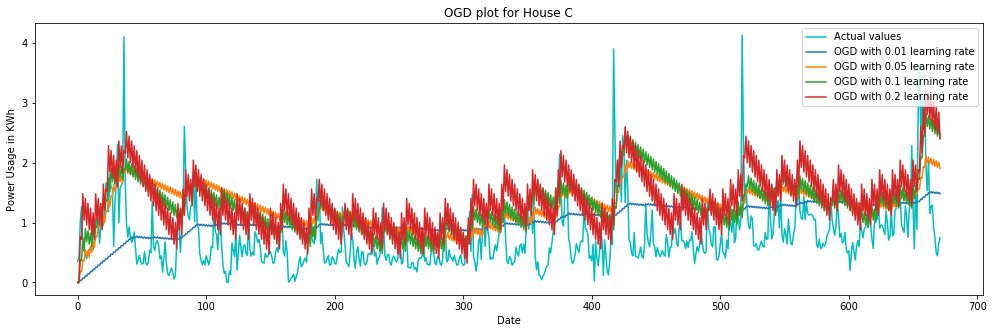

In [41]:
LR = [0.01, 0.05, 0.1, 0.2]
data = np.array(HomeC_MeterData_Nov_Two_weeks['use [kW]'])

p = 0.2
a = 2
b = 2

OGD_vals = []
output_vals = []

for rate in LR:
  x = np.zeros(672)
  s = 0
  for t in range(1, 671):
    if data[t] < x[t]:
      if x[t] > x[t-1]:
        cost = p+b
      else:
        cost = p-b
    else:
      if x[t] > x[t-1]:
        cost = p-a+b
      else:
        cost = p-a-b;

    x[t+1] = x[t] - rate * cost;

  for i in range(1, 671):
    s = s + p*x[i] + a*max(0,data[i] - x[i])+ b*abs(x[i] - x[i-1]);

  OGD_vals.append(x)
  output_vals.append(s)


ind = 0
date = [dt for dt in pd.date_range(HomeC_MeterData_Nov_Two_weeks['Date & Time'][0], HomeC_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]

fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='OGD plot for House C', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for rate in LR:
  plt.plot(OGD_vals[ind], label='OGD with '+ str(rate) + ' learning rate')
  plt.legend(loc='upper right')
  ind = ind+1

plt.show()


In [42]:
output_vals

[324.32885667200054, 387.7913288860034, 518.833366664001, 816.6135055540051]

The Result for Power usage is as below

1.   For learning rate 0.01 :   324.32885667200054
2.   For learning rate 0.05 :   387.7913288860034
3.   For learning rate 0.1 :   518.833366664001
4.   For learning rate 0.2 :   816.6135055540051


**House F**

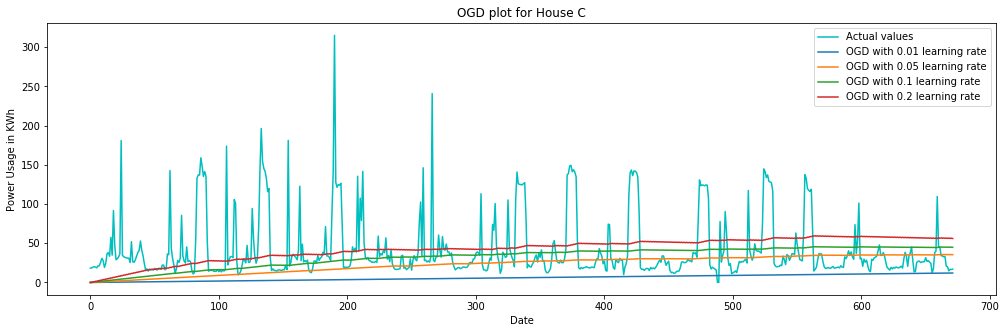

In [43]:
LR = [0.01, 0.05, 0.1, 0.2]
data = np.array(HomeF_MeterData_Nov_Two_weeks['Usage [kW]'])

p = 0.2
a = 2
b = 2

OGD_vals = []
output_vals = []

for rate in LR:
  x = np.zeros(672)
  s = 0
  for t in range(1, 671):
    if data[t] < x[t]:
      if x[t] > x[t-1]:
        cost = p+b
      else:
        cost = p-b
    else:
      if x[t] > x[t-1]:
        cost = p-a+b
      else:
        cost = p-a-b;

    x[t+1] = x[t] - rate * cost;

  for i in range(1, 671):
    s = s + p*x[i] + a*max(0,data[i] - x[i])+ b*abs(x[i] - x[i-1]);

  OGD_vals.append(x)
  output_vals.append(s)


ind = 0
date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]

fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='OGD plot for House C', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for rate in LR:
  plt.plot(OGD_vals[ind], label='OGD with '+ str(rate) + ' learning rate')
  plt.legend(loc='upper right')
  ind = ind+1

plt.show()


In [44]:
output_vals

[49961.13760012446, 34088.1207667563, 29513.49870006194, 26691.517533394184]

The Result for Power usage is as below

1.   For learning rate 0.01 :   49961.13760012446
2.   For learning rate 0.05 :   34088.1207667563
3.   For learning rate 0.1 :   29513.49870006194
4.   For learning rate 0.2 :   26691.517533394184


# Receding Horizon Control

In [45]:
HomeB_PredData_RF = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/HouseB_Pred_RF.csv')
HomeC_PredData_RF = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/HouseC_Pred_RF.csv')
HomeF_PredData_RF = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/HouseF_Pred_RF.csv')


HomeB_PredData_LSTM = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/LSTM_HouseB_Data.csv')
HomeC_PredData_LSTM = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/LSTM_HouseB_Data.csv')
HomeF_PredData_LSTM = pd.read_csv('/Users/rajesh/Desktop/AMS_559_Smart_Energy/data/LSTM_HouseB_Data.csv')

**House B**

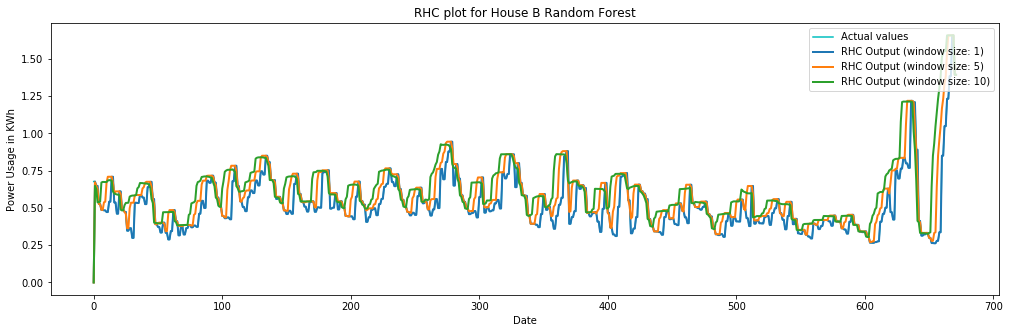

In [46]:
data=np.array(HomeB_PredData_RF['prediction'])
p = 0.2
a = 2
b = 2
windows = [1,5,10]
x_vals = []
RHC_vals = []

for window in windows:
  x_1 = [0]
  y_pred = list(data)
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+window]
    x = cp.Variable(window)
    sum = 0
    
    for i in range(0,min(window, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    x_1.append(x.value[0])

  cost = 0
  for i in range(1,len(x_1)):
    cost += p*x_1[i] + a*max(0, y_pred[i] - x_1[i]) + b*abs(x_1[i] - x_1[i-1])
    # print(cost)
  x_vals.append(x_1)
  RHC_vals.append(cost)
    
date = [dt for dt in pd.date_range(HomeB_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeB_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House B Random Forest', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for window in range(0, len(windows)):
  plt.plot(x_vals[window],linewidth=2, label="RHC Output (window size: "+ str(windows[window]) +")")
  plt.legend(loc='upper right')

plt.show()

In [47]:
RHC_vals

[122.04217459560344, 119.65530138196286, 127.69711203644857]

The Result for Power usage is as below

1.   For learning rate 0.01 :   122.04217459560344
2.   For learning rate 0.05 :   119.65530138196286
3.   For learning rate 0.1 :   127.69711203644857



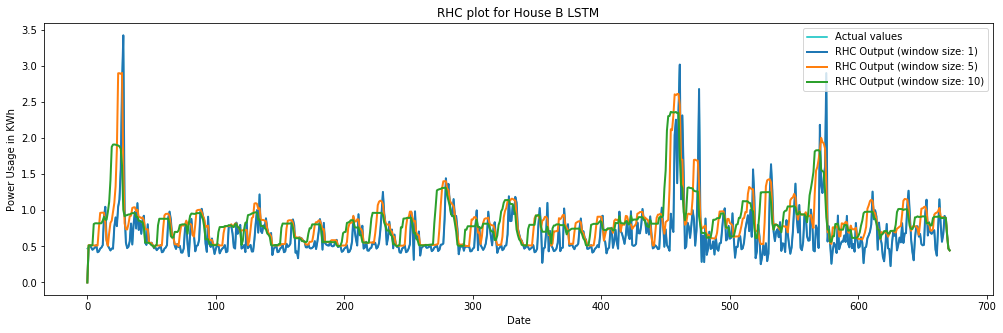

In [48]:
data=np.array(HomeB_PredData_LSTM['Predictions'])
p = 0.2
a = 2
b = 2
windows = [1,5,10]
x_vals = []
RHC_vals = []

for window in windows:
  x_1 = [0]
  y_pred = list(data)
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+window]
    x = cp.Variable(window)
    sum = 0
    
    for i in range(0,min(window, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    x_1.append(x.value[0])

  cost = 0
  for i in range(1,len(x_1)):
    cost += p*x_1[i] + a*max(0, y_pred[i] - x_1[i]) + b*abs(x_1[i] - x_1[i-1])
    # print(cost)
  x_vals.append(x_1)
  RHC_vals.append(cost)
    
date = [dt for dt in pd.date_range(HomeB_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeB_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House B LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for window in range(0, len(windows)):
  plt.plot(x_vals[window],linewidth=2, label="RHC Output (window size: "+ str(windows[window]) +")")
  plt.legend(loc='upper right')

plt.show()

In [49]:
RHC_vals

[333.93520897885304, 235.1704931585992, 230.89959783525]

The Result for Power usage is as below

1.   For learning rate 0.01 :   333.93520897885304
2.   For learning rate 0.05 :   235.1704931585992
3.   For learning rate 0.1 :   230.89959783525



**House C**

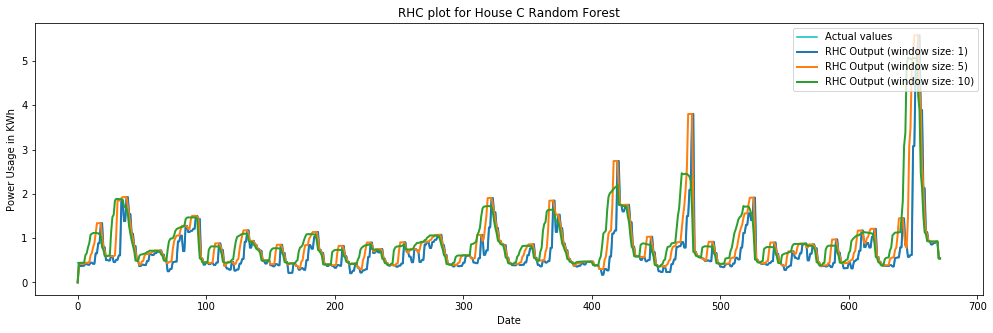

In [50]:
data=np.array(HomeC_PredData_RF['prediction'])
p = 0.2
a = 2
b = 2
windows = [1,5,10]
x_vals = []
RHC_vals = []

for window in windows:
  x_1 = [0]
  y_pred = list(data)
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+window]
    x = cp.Variable(window)
    sum = 0
    
    for i in range(0,min(window, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    x_1.append(x.value[0])

  cost = 0
  for i in range(1,len(x_1)):
    cost += p*x_1[i] + a*max(0, y_pred[i] - x_1[i]) + b*abs(x_1[i] - x_1[i-1])
    # print(cost)
  x_vals.append(x_1)
  RHC_vals.append(cost)
    
date = [dt for dt in pd.date_range(HomeC_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeC_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House C Random Forest', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for window in range(0, len(windows)):
  plt.plot(x_vals[window],linewidth=2, label="RHC Output (window size: "+ str(windows[window]) +")")
  plt.legend(loc='upper right')

plt.show()

In [51]:
RHC_vals

[241.47099800529554, 262.76482948372353, 294.96428425817084]

The Result for Power usage is as below

1.   For learning rate 0.01 :   241.47099800529554
2.   For learning rate 0.05 :   262.76482948372353
3.   For learning rate 0.1 :   294.96428425817084


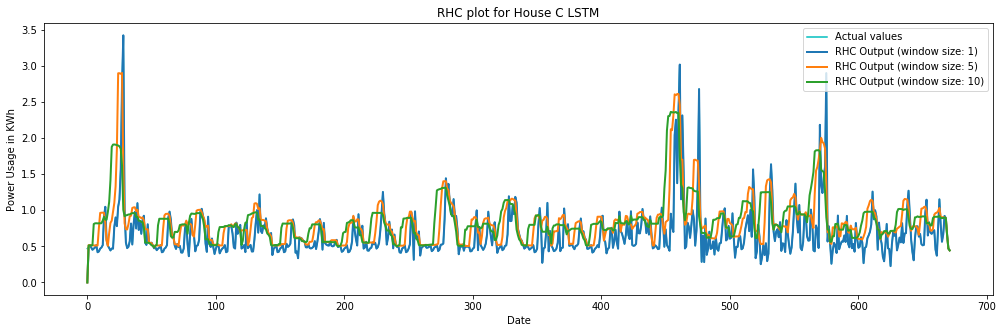

In [52]:
data=np.array(HomeC_PredData_LSTM['Predictions'])
p = 0.2
a = 2
b = 2
windows = [1,5,10]
x_vals = []
RHC_vals = []

for window in windows:
  x_1 = [0]
  y_pred = list(data)
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+window]
    x = cp.Variable(window)
    sum = 0
    
    for i in range(0,min(window, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    x_1.append(x.value[0])

  cost = 0
  for i in range(1,len(x_1)):
    cost += p*x_1[i] + a*max(0, y_pred[i] - x_1[i]) + b*abs(x_1[i] - x_1[i-1])
    # print(cost)
  x_vals.append(x_1)
  RHC_vals.append(cost)
    
date = [dt for dt in pd.date_range(HomeC_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeC_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]
                                     

fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House C LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for window in range(0, len(windows)):
  plt.plot(x_vals[window],linewidth=2, label="RHC Output (window size: "+ str(windows[window]) +")")
  plt.legend(loc='upper right')

plt.show()

In [53]:
RHC_vals

[333.93520897885304, 235.1704931585992, 230.89959783525]

The Result for Power usage is as below

1.   For learning rate 0.01 :   420.4770071192324
2.   For learning rate 0.05 :   281.2044203225728
3.   For learning rate 0.1 :   269.84108297746667


**House F**

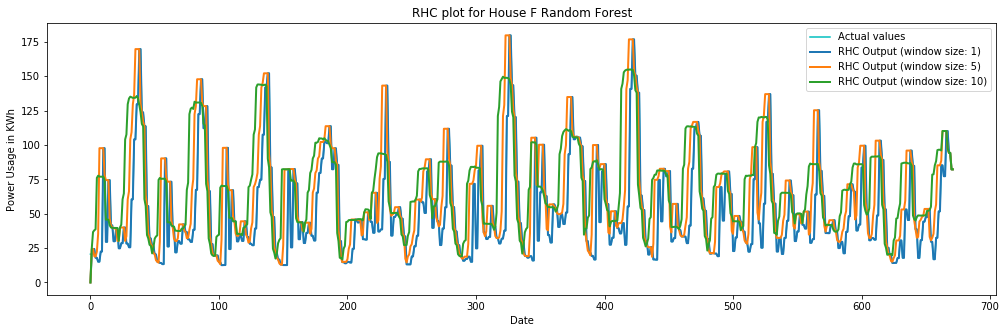

In [54]:
data=np.array(HomeF_PredData_RF['prediction'])
p = 0.2
a = 2
b = 2
windows = [1,5,10]
x_vals = []
RHC_vals = []

for window in windows:
  x_1 = [0]
  y_pred = list(data)
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+window]
    x = cp.Variable(window)
    sum = 0
    
    for i in range(0,min(window, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    x_1.append(x.value[0])

  cost = 0
  for i in range(1,len(x_1)):
    cost += p*x_1[i] + a*max(0, y_pred[i] - x_1[i]) + b*abs(x_1[i] - x_1[i-1])
    # print(cost)
  x_vals.append(x_1)
  RHC_vals.append(cost)
    
date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House F Random Forest', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for window in range(0, len(windows)):
  plt.plot(x_vals[window],linewidth=2, label="RHC Output (window size: "+ str(windows[window]) +")")
  plt.legend(loc='upper right')

plt.show()

In [55]:
RHC_vals

[21347.229150116567, 24276.92687796217, 24731.449028431944]

The Result for Power usage is as below

1.   For learning rate 0.01 :   21347.229150116567
2.   For learning rate 0.05 :   24276.92687796217
3.   For learning rate 0.1 :   24731.449028431944



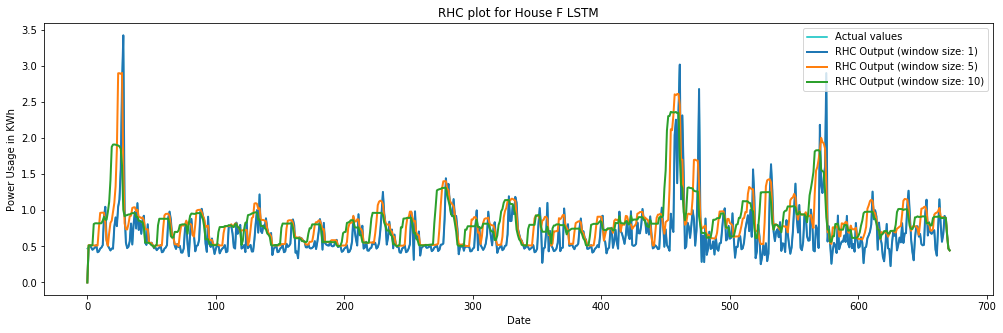

In [56]:
data=np.array(HomeF_PredData_LSTM['Predictions'])
p = 0.2
a = 2
b = 2
windows = [1,5,10]
x_vals = []
RHC_vals = []

for window in windows:
  x_1 = [0]
  y_pred = list(data)
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+window]
    x = cp.Variable(window)
    sum = 0
    
    for i in range(0,min(window, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    x_1.append(x.value[0])

  cost = 0
  for i in range(1,len(x_1)):
    cost += p*x_1[i] + a*max(0, y_pred[i] - x_1[i]) + b*abs(x_1[i] - x_1[i-1])
    # print(cost)
  x_vals.append(x_1)
  RHC_vals.append(cost)
    
date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House F LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(data, 'c', label="Actual values")

for window in range(0, len(windows)):
  plt.plot(x_vals[window],linewidth=2, label="RHC Output (window size: "+ str(windows[window]) +")")
  plt.legend(loc='upper right')

plt.show()

In [57]:
RHC_vals

[333.93520897885304, 235.1704931585992, 230.89959783525]

The Result for Power usage is as below

1.   For learning rate 0.01 :   24311.771413128063
2.   For learning rate 0.05 :   20982.22085863215
3.   For learning rate 0.1 :   21489.934634826444

# CHC

**House B**

119.65530138196286
120.85290408405436
121.67540191809343
122.48746394309379


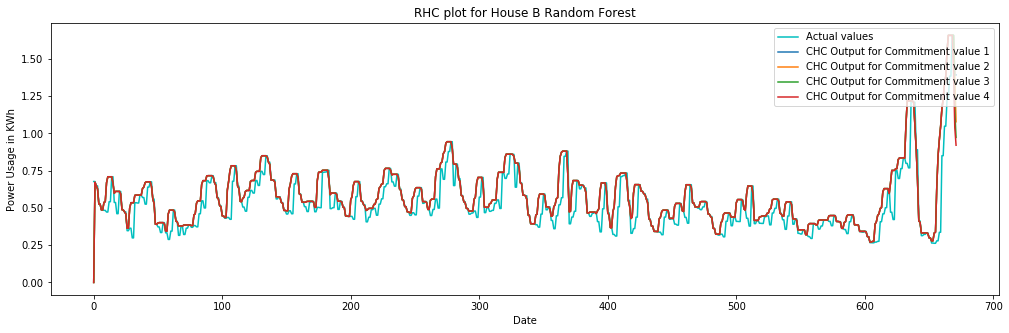

In [58]:
y_pred = np.array(HomeB_PredData_RF['prediction']).tolist()
a = 2
b = 2
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []


for commit_hor in commitment_vals:
  x_vals = [0]
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+pred_Hor]
    x = cp.Variable(pred_Hor)
    sum = 0
    
    for i in range(0,min(pred_Hor, len(y))):
      sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for gg in range(0,commit_hor):
      avg += x.value[gg]/commit_hor
    x_vals.append(avg)

  all_x_vals.append(x_vals)
  chc_cost = 0
  for i in range(1,len(x_vals)):
    chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
  print(chc_cost)
  chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House B Random Forest', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [59]:
chc_vals

[119.65530138196286,
 120.85290408405436,
 121.67540191809343,
 122.48746394309379]

The Result for Power usage is as below

1.   For commitment value 1 : 119.65530138196286
2.   For commitment value 2 : 120.85290408405436
3.   For commitment value 3 : 121.67540191809343
4.   For commitment value 4 : 122.48746394309379


235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528


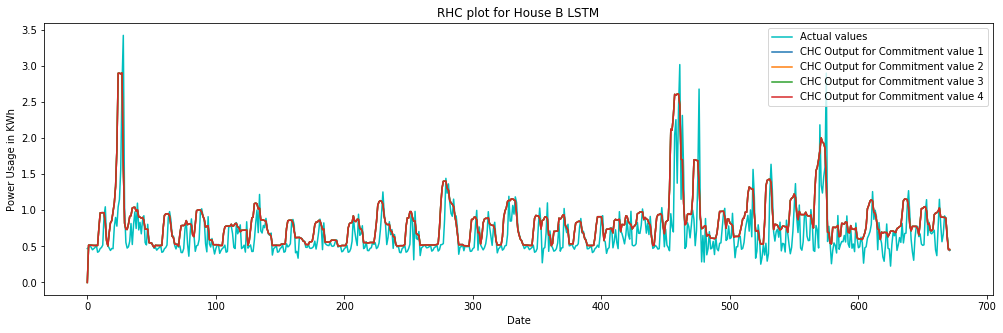

In [60]:
y_pred = np.array(HomeB_PredData_LSTM['Predictions']).tolist()
a = 2
b = 2
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []


for commit_hor in commitment_vals:
  x_vals = [0]
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+pred_Hor]
    x = cp.Variable(pred_Hor)
    sum = 0
    
    for i in range(0,min(pred_Hor, len(y))):
      sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for gg in range(0,commit_hor):
      avg += x.value[gg]/commit_hor
    x_vals.append(avg)

  all_x_vals.append(x_vals)
  chc_cost = 0
  for i in range(1,len(x_vals)):
    chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
  print(chc_cost)
  chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House B LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [61]:
chc_vals

[235.1704931585992, 235.15559077368195, 235.171955638127, 235.27378014386528]

The Result for Power usage is as below

1.   For commitment value 1 : 235.1704931585992
2.   For commitment value 2 : 235.15559077368195
3.   For commitment value 3 : 235.171955638127
4.   For commitment value 4 : 235.27378014386528

**House C**

262.76482948372353
262.85983606475327
262.9458111332126
263.1703063734835


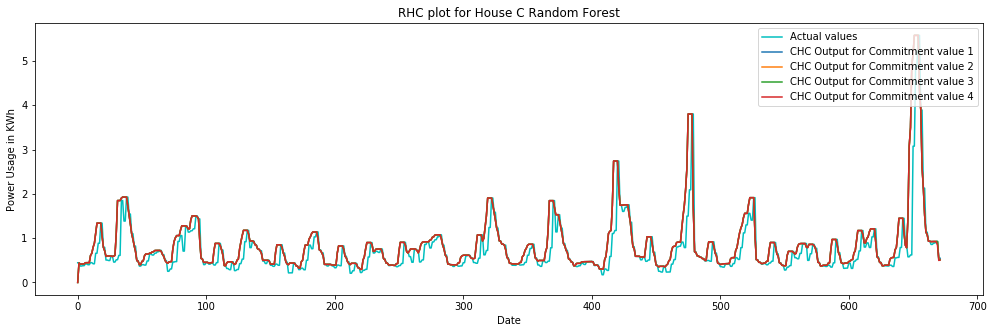

In [62]:
y_pred = np.array(HomeC_PredData_RF['prediction']).tolist()
a = 2
b = 2
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []


for commit_hor in commitment_vals:
  x_vals = [0]
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+pred_Hor]
    x = cp.Variable(pred_Hor)
    sum = 0
    
    for i in range(0,min(pred_Hor, len(y))):
      sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for gg in range(0,commit_hor):
      avg += x.value[gg]/commit_hor
    x_vals.append(avg)

  all_x_vals.append(x_vals)
  chc_cost = 0
  for i in range(1,len(x_vals)):
    chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
  print(chc_cost)
  chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House C Random Forest', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [63]:
chc_vals

[262.76482948372353, 262.85983606475327, 262.9458111332126, 263.1703063734835]

The Result for Power usage is as below

1.   For commitment value 1 : 262.76482948372353
2.   For commitment value 2 : 262.85983606475327
3.   For commitment value 3 : 262.9458111332126
4.   For commitment value 4 : 263.1703063734835

235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528


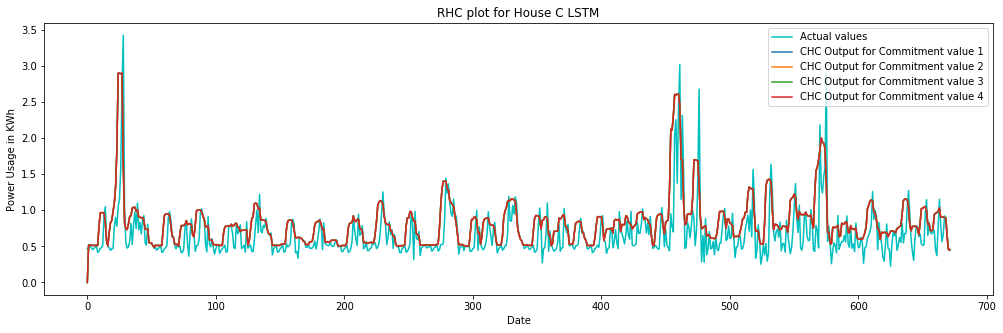

In [64]:
y_pred = np.array(HomeC_PredData_LSTM['Predictions']).tolist()
a = 2
b = 2
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []


for commit_hor in commitment_vals:
  x_vals = [0]
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+pred_Hor]
    x = cp.Variable(pred_Hor)
    sum = 0
    
    for i in range(0,min(pred_Hor, len(y))):
      sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for gg in range(0,commit_hor):
      avg += x.value[gg]/commit_hor
    x_vals.append(avg)

  all_x_vals.append(x_vals)
  chc_cost = 0
  for i in range(1,len(x_vals)):
    chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
  print(chc_cost)
  chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House C LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [65]:
chc_vals

[235.1704931585992, 235.15559077368195, 235.171955638127, 235.27378014386528]

The Result for Power usage is as below

1.   For commitment value 1 : 281.2044203225728
2.   For commitment value 2 : 281.2099378415188
3.   For commitment value 3 : 281.2517475533728
4.   For commitment value 4 : 281.4492131997757

**House F**

24276.92687796217
24383.283813498554
24454.54569275452
24520.395984083047


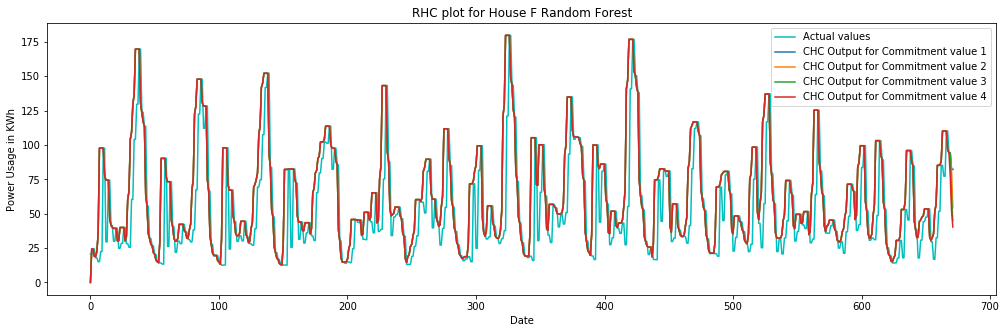

In [66]:
y_pred = np.array(HomeF_PredData_RF['prediction']).tolist()
a = 2
b = 2
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []


for commit_hor in commitment_vals:
  x_vals = [0]
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+pred_Hor]
    x = cp.Variable(pred_Hor)
    sum = 0
    
    for i in range(0,min(pred_Hor, len(y))):
      sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for gg in range(0,commit_hor):
      avg += x.value[gg]/commit_hor
    x_vals.append(avg)

  all_x_vals.append(x_vals)
  chc_cost = 0
  for i in range(1,len(x_vals)):
    chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
  print(chc_cost)
  chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House F Random Forest', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [67]:
chc_vals

[24276.92687796217, 24383.283813498554, 24454.54569275452, 24520.395984083047]

The Result for Power usage is as below

1.   For commitment value 1 : 24276.92687796217
2.   For commitment value 2 :  24383.283813498554
3.   For commitment value 3 : 24454.54569275452
4.   For commitment value 4 : 24520.395984083047

235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528


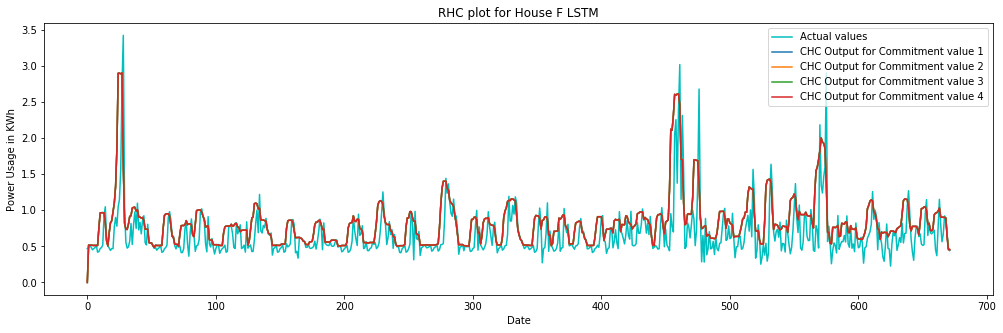

In [68]:
y_pred = np.array(HomeF_PredData_LSTM['Predictions']).tolist()
a = 2
b = 2
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []


for commit_hor in commitment_vals:
  x_vals = [0]
  for t in range(1,len(y_pred)):
    y = y_pred[t:t+pred_Hor]
    x = cp.Variable(pred_Hor)
    sum = 0
    
    for i in range(0,min(pred_Hor, len(y))):
      sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
      
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for gg in range(0,commit_hor):
      avg += x.value[gg]/commit_hor
    x_vals.append(avg)

  all_x_vals.append(x_vals)
  chc_cost = 0
  for i in range(1,len(x_vals)):
    chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
  print(chc_cost)
  chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House F LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [69]:
chc_vals

[235.1704931585992, 235.15559077368195, 235.171955638127, 235.27378014386528]

The Result for Power usage is as below

1.   For commitment value 1 : 20982.22085863215
2.   For commitment value 2 :  21000.979495701533
3.   For commitment value 3 : 21013.8953148354
4.   For commitment value 4 : 21024.689848402635

# **Cost Compararision of online algorithms to those of the offline static and dynamic solutions.**

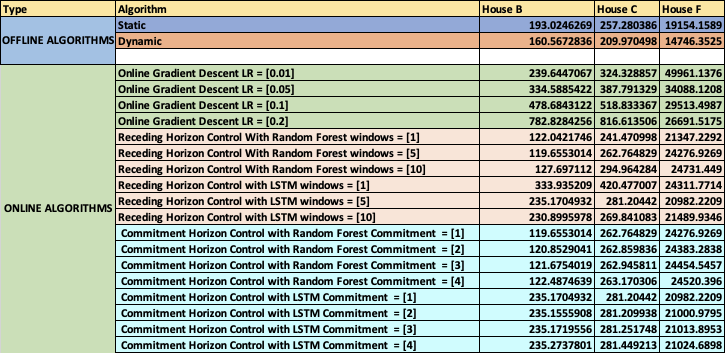

# **Varing a and b values for CHC with LSTM**




219.39778775241516
219.38288536462082
219.38739893510484
219.44251579080134
235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528
266.71590397096793
266.70100159180373
266.7410690441716
266.93630884999334
298.26131478333673
298.24641240992617
298.3101824502159
298.59883755612117
329.8067255957054
329.791823228048
329.87929585626034
330.2613662622487


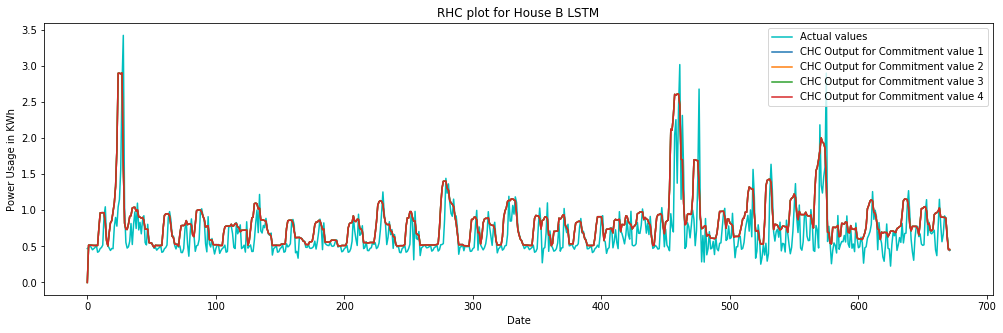

In [70]:
y_pred = np.array(HomeB_PredData_LSTM['Predictions']).tolist()
a_vals = [1,2,4,6,8]
b = 2
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []

for a in a_vals:
  for commit_hor in commitment_vals:
    x_vals = [0]
    for t in range(1,len(y_pred)):
      y = y_pred[t:t+pred_Hor]
      x = cp.Variable(pred_Hor)
      sum = 0
      
      for i in range(0,min(pred_Hor, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
        
      objective = (cp.Minimize(sum))
      constraints = [0 <= x]
      prob = cp.Problem(objective, constraints)
      result = prob.solve()
      avg = 0
      for gg in range(0,commit_hor):
        avg += x.value[gg]/commit_hor
      x_vals.append(avg)

    all_x_vals.append(x_vals)
    chc_cost = 0
    for i in range(1,len(x_vals)):
      chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
    print(chc_cost)
    chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House B LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [71]:
chc_vals

[219.39778775241516,
 219.38288536462082,
 219.38739893510484,
 219.44251579080134,
 235.1704931585992,
 235.15559077368195,
 235.171955638127,
 235.27378014386528,
 266.71590397096793,
 266.70100159180373,
 266.7410690441716,
 266.93630884999334,
 298.26131478333673,
 298.24641240992617,
 298.3101824502159,
 298.59883755612117,
 329.8067255957054,
 329.791823228048,
 329.87929585626034,
 330.2613662622487]

189.20165550243036
189.1950322232569
189.21415679030022
189.3072439133453
235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528
327.1081684709378
327.0767078745321
327.08755333378144
327.2068526049057
419.04584378327644
418.997824975382
419.003151029436
419.1399250659462
510.9835190956153
510.9189420762315
510.91874872509015
511.0729975269865


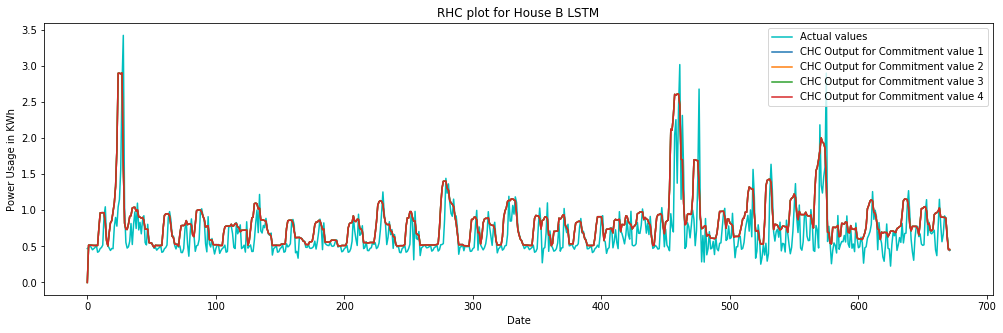

In [72]:
y_pred = np.array(HomeB_PredData_LSTM['Predictions']).tolist()
a = 2
b_vals = [1,2,4,6,8]
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []

for b in b_vals:
  for commit_hor in commitment_vals:
    x_vals = [0]
    for t in range(1,len(y_pred)):
      y = y_pred[t:t+pred_Hor]
      x = cp.Variable(pred_Hor)
      sum = 0
      
      for i in range(0,min(pred_Hor, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
        
      objective = (cp.Minimize(sum))
      constraints = [0 <= x]
      prob = cp.Problem(objective, constraints)
      result = prob.solve()
      avg = 0
      for gg in range(0,commit_hor):
        avg += x.value[gg]/commit_hor
      x_vals.append(avg)

    all_x_vals.append(x_vals)
    chc_cost = 0
    for i in range(1,len(x_vals)):
      chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
    print(chc_cost)
    chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House B LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [73]:
chc_vals

[189.20165550243036,
 189.1950322232569,
 189.21415679030022,
 189.3072439133453,
 235.1704931585992,
 235.15559077368195,
 235.171955638127,
 235.27378014386528,
 327.1081684709378,
 327.0767078745321,
 327.08755333378144,
 327.2068526049057,
 419.04584378327644,
 418.997824975382,
 419.003151029436,
 419.1399250659462,
 510.9835190956153,
 510.9189420762315,
 510.91874872509015,
 511.0729975269865]

173.42895009624598
173.4223268141959
173.42960008727795
173.47597956028153
235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528
358.6535792833065
358.62211869265377
358.65666673982577
358.8693813110335
482.13666540801376
482.0886466116259
482.1413778415249
482.4649824782019
605.6197515327204
605.555174530597
605.6260889432237
606.0605836453698


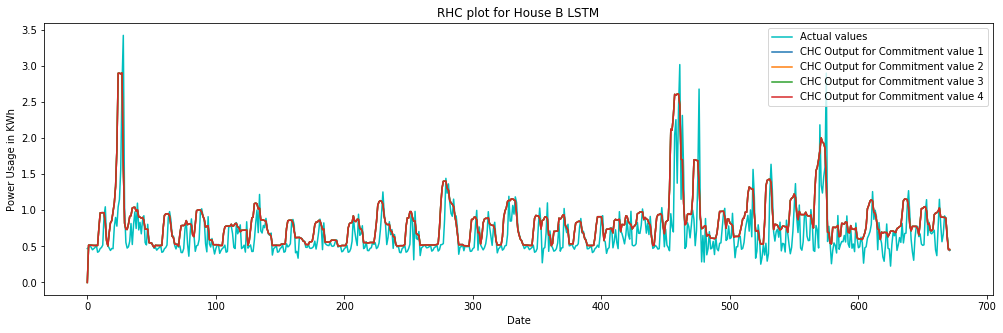

In [74]:
y_pred = np.array(HomeB_PredData_LSTM['Predictions']).tolist()
a_vals = [1,2,4,6,8]
b_vals = [1,2,4,6,8]
p = 0.2
pred_Hor = 5
commitment_vals = [1, 2, 3, 4]
all_x_vals = []
chc_vals = []

for i in range(0, len(b_vals)):
  a = a_vals[i]
  b = b_vals[i]
  for commit_hor in commitment_vals:
    x_vals = [0]
    for t in range(1,len(y_pred)):
      y = y_pred[t:t+pred_Hor]
      x = cp.Variable(pred_Hor)
      sum = 0
      
      for i in range(0,min(pred_Hor, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
        
      objective = (cp.Minimize(sum))
      constraints = [0 <= x]
      prob = cp.Problem(objective, constraints)
      result = prob.solve()
      avg = 0
      for gg in range(0,commit_hor):
        avg += x.value[gg]/commit_hor
      x_vals.append(avg)

    all_x_vals.append(x_vals)
    chc_cost = 0
    for i in range(1,len(x_vals)):
      chc_cost += p*x_vals[i] + a*max(0, y_pred[i] - x_vals[i]) + b*abs(x_vals[i] - x_vals[i-1])
    print(chc_cost)
    chc_vals.append(chc_cost)


date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                     HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]


fig, axes = plt.subplots(figsize=(17, 5))
axes.set(title='RHC plot for House B LSTM', xlabel='Date', ylabel='Power Usage in KWh')
plt.plot(y_pred, 'c', label="Actual values")

for i in range(0, len(commitment_vals)):
  plt.plot(all_x_vals[i], label="CHC Output for Commitment value "+ str(commitment_vals[i]))
  
plt.legend(loc='upper right')
plt.show()

In [75]:
chc_vals

[173.42895009624598,
 173.4223268141959,
 173.42960008727795,
 173.47597956028153,
 235.1704931585992,
 235.15559077368195,
 235.171955638127,
 235.27378014386528,
 358.6535792833065,
 358.62211869265377,
 358.65666673982577,
 358.8693813110335,
 482.13666540801376,
 482.0886466116259,
 482.1413778415249,
 482.4649824782019,
 605.6197515327204,
 605.555174530597,
 605.6260889432237,
 606.0605836453698]

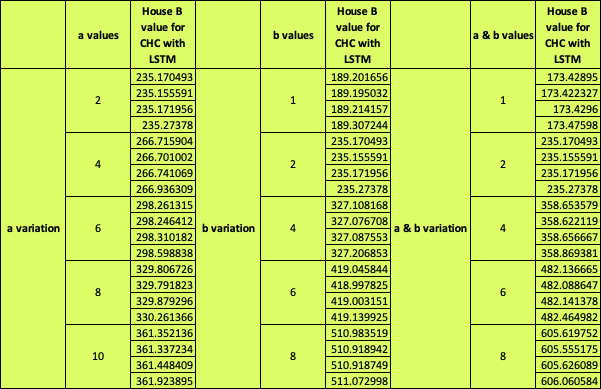

In [ ]:
Algorithm selection Deterministic Randomized

In [ ]:
rhc = get_RHC()
chc = get_CHC()
ogd = get_OGD_vals()
y = np.array(HomeB_MeterData_Nov_Two_weeks['use [kW]']).tolist()
  # Equal priority
w= [1/3] * 3
p = [1/3] * 3
experts = list(zip(ogd, rhc, chc) )

for t in range(672):
  denom = 0
  for i in range(3):
    denom += w[i]
    # Calulate priorities based on the weights
  for i in range(3):
    p[i] = w[i]/denom
    # Randomly pick a value based on the probablities
  index = np.random.choice([0,1,2], p = p[:3])
  if (abs(experts[t][index] - y[t]) >= diff): # Check the difference
    w[index] = w[index] * (1 - e)


In [76]:
def get_OGD_vals():
  LR = [0.01, 0.05, 0.1, 0.2]
  data = np.array(HomeB_MeterData_Nov_Two_weeks['use [kW]'])

  p = 0.2
  a = 2
  b = 2

  OGD_vals = []
  output_vals = []

  for rate in LR:
    x = np.zeros(672)
    s = 0
    for t in range(1, 671):
      if data[t] < x[t]:
        if x[t] > x[t-1]:
          cost = p+b
        else:
          cost = p-b
      else:
        if x[t] > x[t-1]:
          cost = p-a+b
        else:
          cost = p-a-b;

      x[t+1] = x[t] - rate * cost;

    for i in range(1, 671):
      s = s + p*x[i] + a*max(0,data[i] - x[i])+ b*abs(x[i] - x[i-1]);

    OGD_vals.append(x)
    output_vals.append(s)

  ind = 0
  date = [dt for dt in pd.date_range(HomeB_MeterData_Nov_Two_weeks['Date & Time'][0], HomeB_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]

  return OGD_vals[2]



def get_CHC():
  y_pred = np.array(HomeB_PredData_LSTM['Predictions']).tolist()
  a = 2
  b = 2
  p = 0.2
  pred_Hor = 5
  commitment_vals = [1, 2, 3, 4]
  all_x_vals = []
  chc_vals = []


  for commit_hor in commitment_vals:
    ch_x_vals = [0]
    for t in range(1,len(y_pred)):
      y = y_pred[t:t+pred_Hor]
      x = cp.Variable(pred_Hor)
      sum = 0
      
      for i in range(0,min(pred_Hor, len(y))):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
        
      objective = (cp.Minimize(sum))
      constraints = [0 <= x]
      prob = cp.Problem(objective, constraints)
      result = prob.solve()
      avg = 0
      for gg in range(0,commit_hor):
        avg += x.value[gg]/commit_hor
      ch_x_vals.append(avg)

    all_x_vals.append(ch_x_vals)
    chc_cost = 0
    for i in range(1,len(ch_x_vals)):
      chc_cost += p*ch_x_vals[i] + a*max(0, y_pred[i] - ch_x_vals[i]) + b*abs(ch_x_vals[i] - ch_x_vals[i-1])
    print(chc_cost)
    chc_vals.append(chc_cost)


  date = [dt for dt in pd.date_range(HomeF_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                      HomeF_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]
  return ch_x_vals


def get_RHC():
  data=np.array(HomeB_PredData_LSTM['Predictions'])
  p = 0.2
  a = 2
  b = 2
  windows = [1,5]
  x_vals = []
  RHC_vals = []

  for window in windows:
    x_1 = [0]
    y_pred = list(data)
    for t in range(1,len(y_pred)):
      y = y_pred[t:t+window]
      x = cp.Variable(window)
      sum = 0
      
      for i in range(0,min(window, len(y))):
          sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
        
      objective = (cp.Minimize(sum))
      constraints = [0 <= x]
      prob = cp.Problem(objective, constraints)
      result = prob.solve()
      x_1.append(x.value[0])

    cost = 0
    for i in range(1,len(x_1)):
      cost += p*x_1[i] + a*max(0, y_pred[i] - x_1[i]) + b*abs(x_1[i] - x_1[i-1])
      # print(cost)
    x_vals.append(x_1)
    RHC_vals.append(cost)
    
  date = [dt for dt in pd.date_range(HomeB_MeterData_Nov_Two_weeks['Date & Time'][0], 
                                      HomeB_MeterData_Nov_Two_weeks['Date & Time'][671], periods = 672).tolist()]
  return x_vals[1]


In [77]:
rhc = get_RHC()
chc = get_CHC()
ogd = get_OGD_vals()
y = np.array(HomeB_MeterData_Nov_Two_weeks['use [kW]']).tolist()
det_w= [1/3] * 3
p = [1/3] * 3
experts = list(zip(ogd, rhc, chc) )

for val in range(len(y)):
  denom = 0
  for i in range(3):
    denom += det_w[i]
  for i in range(3):
    p[i] = det_w[i]/denom
  ind = np.random.choice([0,1,2], p = p[:3])
  if (abs(experts[val][ind] - y[val]) >= 0.1): 
    det_w[ind] = det_w[ind] * (1 - 0.01)



235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528


In [80]:
rhc = get_RHC()
chc = get_CHC()
ogd = get_OGD_vals()
y = np.array(HomeB_MeterData_Nov_Two_weeks['use [kW]']).tolist()

rand_w= [1/3] * 3
p = [1/3] * 3
experts = list(zip(ogd, rhc, chc) )
for val in range(len(y)):
  denom = 0
  for i in range(3):
    denom += rand_w[i]
  for i in range(3):
    p[i] = rand_w[i]/denom
  ind = np.random.choice([0,1,2], p = p[:3])
  if (abs(experts[val][ind] - y[val]) >= 0.1):
    rand_w[ind] = rand_w[ind] * (1 - 0.01)


235.1704931585992
235.15559077368195
235.171955638127
235.27378014386528


In [81]:
print(det_w)
print(rand_w)

[0.05140731726461482, 0.06477619962759827, 0.061601521316182024]
[0.04988046853453849, 0.060985506103020205, 0.06609141886297142]


In [ ]:
The performance of deterministic and randomized algorithm is as below

Deterministic : [0.0007936530661326516, 0.002546526061073689, 0.002546526061073689]
Randomized : [0.0007936530661326516, 0.002546526061073689, 0.002546526061073689]